# Contextual Bandits data

## Load data

In [1]:
# Initialize Workspace
from azureml.core import Workspace
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: rlos-cfe-aml
Azure region: eastus
Subscription id: 98ef7fe8-6707-4324-b08e-8a2e663d8f34
Resource group: rlos_cfe2021


In [2]:
# Create or Attach AML Compute
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = ""

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-07-15T03:30:10.452000+00:00', 'errors': None, 'creationTime': '2021-05-11T15:30:36.513512+00:00', 'modifiedTime': '2021-05-11T15:31:22.013501+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_DS2_V2'}


In [3]:
import shutil, os
source_directory = 'script-run'
shutil.rmtree(source_directory)
os.makedirs(source_directory, exist_ok=True)
shutil.copytree('cb', os.path.join(source_directory, 'cb'))

'script-run/cb'

In [4]:
%%writefile $source_directory/setup_mpi.py
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
import sys
import os
from mpi4py import MPI
import pandas as pd

mounted_input_path = sys.argv[1]
mounted_output_path = sys.argv[2]

print("Argument 1: %s" % mounted_input_path)
print("Argument 2: %s" % mounted_output_path)
print("Number of nodes {}:".format(MPI.COMM_WORLD.Get_size()))
print("Node index {}:".format(MPI.COMM_WORLD.Get_rank()))

even = []
odd = [] 

input_file_list = os.listdir(mounted_input_path)
print("File number: {}".format(len(input_file_list)))
for index in range(0, len(input_file_list)):
    if index % 2 == 0:
        even.append(input_file_list[index])
        print("read in {} file".format(input_file_list[index]))
    else:
        odd.append(input_file_list[index])
        print("read in {} file".format(input_file_list[index]))
print(even, odd)
 
config = {
   'policies': {'random': ['ips', 'snips'], 'baseline1': ['ips']},
   'aggregation': {'num_of_events': 10}
}

input_files = []
if MPI.COMM_WORLD.Get_rank() == 0:
    input_files = odd
elif MPI.COMM_WORLD.Get_rank() == 1:
    input_files = even
# estimate(input_files, config)

Writing script-run/setup_mpi.py


In [5]:
def_blob_store = ws.get_default_datastore()
print(def_blob_store)
import sys
for p in sys.path:
    print(p)
print(sys.path)
def_blob_store.upload_files(files = ["test_data/cb/01.csv", "test_data/cb/02.csv", "test_data/cb/03.csv","test_data/cb/04.csv"],
                        target_path = '/dataset/cb/',
                        overwrite = True,
                        show_progress = True)

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-5cb75d62-5e97-45de-99a3-fa348a82842c",
  "account_name": "rloscfestorage",
  "protocol": "https",
  "endpoint": "core.windows.net"
}
/Users/krystalmaughan/Desktop/AzureTest/datascience/data-science/from_mwt_ds/DataScience
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python37.zip
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7/lib-dynload

/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7/site-packages
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7/site-packages/aeosa
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7/site-packages/vw_estimators-0.0.1-py3.7.egg
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7/site-packages/vw_executor-0.0.1-py3.7.egg
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg
/Users/krystalmaughan/anaconda3/envs/azureenv/lib/py

$AZUREML_DATAREFERENCE_5bf04d6aab524872b11a93816f7f038b

In [6]:
from azureml.core import Dataset
from azureml.data import OutputFileDatasetConfig

input_data = Dataset.File.from_files(def_blob_store.path('/dataset/cb/*')).as_named_input('input').as_mount()
output = OutputFileDatasetConfig(destination=(def_blob_store, 'sample/outputdataset'))

In [7]:
from azureml.core import Environment
from azureml.core.runconfig import DockerConfiguration
from azureml.core.conda_dependencies import CondaDependencies

myenv = Environment("myenv")

myenv.docker.enabled = True
myenv.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk>=1.12.0', 'pandas','matplotlib','mpi4py','vw-estimators'])
myenv.docker.base_image = 'mcr.microsoft.com/azureml/intelmpi2018.3-cuda9.0-cudnn7-ubuntu16.04'
docker_config = DockerConfiguration(use_docker=True)

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [8]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import MpiConfiguration

src = ScriptRunConfig(source_directory=source_directory, 
                      script='setup_mpi.py', 
                      # to mount the dataset on the remote compute and pass the mounted path as an argument to the training script
                      arguments =[input_data, output],
                      compute_target=compute_target,
                      environment=myenv,
                      distributed_job_config=MpiConfiguration(node_count=2))

In [9]:
## Build and Submit Experiment
from azureml.core import Experiment
exp = Experiment(ws, 'ScriptRun_parallel')
run = exp.submit(config=src)

In [ ]:
# View Run Details
run.wait_for_completion(show_output=True)

RunId: ScriptRun_parallel_1626356910_5ac82d62
Web View: https://ml.azure.com/runs/ScriptRun_parallel_1626356910_5ac82d62?wsid=/subscriptions/98ef7fe8-6707-4324-b08e-8a2e663d8f34/resourcegroups/rlos_cfe2021/workspaces/rlos-cfe-aml&tid=43f90318-9a31-4f25-8b9d-fe3023853a8c

Streaming azureml-logs/55_azureml-execution-tvmps_5a56367b4fdc43b744dd97b823ee19d748a1a0911d1a18ef505b75b652137d15_d.txt

2021-07-15T13:51:36Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/rlos-cfe-aml/azureml/scriptrun_parallel_1626356910_5ac82d62/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/rlos-cfe-aml/azureml/scriptrun_parallel_1626356910_5ac82d62/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=11466 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/rlos-cfe-aml/azureml/scriptrun_parallel_1626356910_5ac82d62/configs/workspaceblobstore.cfg --log-level=LOG_WARNING
2021-07-15T13

## Visualize

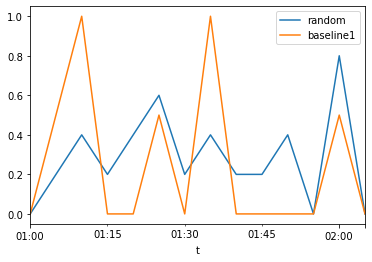

In [8]:
import matplotlib.pyplot as plt

df.apply(lambda r: r['random'].get('snips'), axis=1).plot(label='random')
df.apply(lambda r: r['baseline1'].get('snips'), axis=1).plot(label='baseline1')

plt.legend(loc='best')

## Reaggregate (if needed)

In [9]:
df = df.resample('10min').sum()
df

,random,baseline1
t,,
2021-01-01 01:00:00,<cb.estimators.ips_snips object at 0x123767150>,<cb.estimators.ips_snips object at 0x12394a110>
2021-01-01 01:10:00,<cb.estimators.ips_snips object at 0x123aaef90>,<cb.estimators.ips_snips object at 0x12394ae10>
2021-01-01 01:20:00,<cb.estimators.ips_snips object at 0x123aba050>,<cb.estimators.ips_snips object at 0x12394a9d0>
2021-01-01 01:30:00,<cb.estimators.ips_snips object at 0x123aba0d0>,<cb.estimators.ips_snips object at 0x123aba250>
2021-01-01 01:40:00,<cb.estimators.ips_snips object at 0x123aba110>,<cb.estimators.ips_snips object at 0x123aba210>
2021-01-01 01:50:00,<cb.estimators.ips_snips object at 0x123aba150>,<cb.estimators.ips_snips object at 0x123aba290>
2021-01-01 02:00:00,<cb.estimators.ips_snips object at 0x123aba190>,<cb.estimators.ips_snips object at 0x123aba1d0>


## Visualize

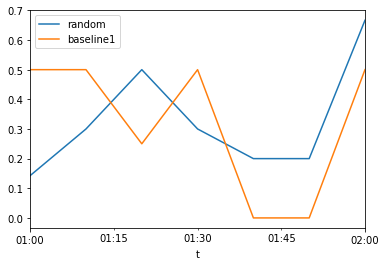

In [10]:
df.apply(lambda r: r['random'].get('snips'), axis=1).plot(label='random')
df.apply(lambda r: r['baseline1'].get('snips'), axis=1).plot(label='baseline1')

plt.legend(loc='best')

# Conditional Contextual Bandits

In [38]:
# import pandas as pd

# df = pd.read_pickle(r'test_data\ccb\01.pickle')
# df.head()